## ANN-LSTM Hybrid Model to Predict the S&P Stock Price

In [810]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
#from plotly.subplots import make_subplot
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn import metrics
import plotly.express as px
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [812]:
#read the dataset from text file into a dataframe
SP_data = pd.read_csv('S&P_500_Historical_Price_Data.csv')

SP_data.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,30/12/2022,"3,839.50","3,829.06","3,839.85","3,800.34",NaN,-0.25%
1,29/12/2022,"3,849.28","3,805.45","3,858.19","3,805.45",NaN,1.75%
2,28/12/2022,"3,783.22","3,829.56","3,848.32","3,780.78",NaN,-1.20%
3,27/12/2022,"3,829.25","3,843.34","3,846.65","3,813.22",NaN,-0.40%
4,23/12/2022,"3,844.82","3,815.11","3,845.80","3,797.01",NaN,0.59%


In [97]:
print(SP_data.dtypes)

Date         object
Price        object
Open         object
High         object
Low          object
Vol.        float64
Change %     object
dtype: object


In [814]:
#make a copy of the dataframe
sp500_data_indexed = SP_data.copy()

In [816]:
#Rename columns for better understanding
SP_data.columns = SP_data.columns.str.replace("Price", "Close Price")
SP_data.columns = SP_data.columns.str.replace("Open", "Open Price")
SP_data.columns = SP_data.columns.str.replace("High", "High Price")
SP_data.columns = SP_data.columns.str.replace("Low", "Low Price")
SP_data.columns = SP_data.columns.str.replace("Vol.", "Volume")
SP_data.columns = SP_data.columns.str.replace("Change %", "Percentage Change")

In [818]:
#convert columns from objects to float

SP_data['Close Price'] = SP_data['Close Price'].apply(lambda x: float(x.split()[0].replace(',', '')))
SP_data['Open Price'] = SP_data['Open Price'].apply(lambda x: float(x.split()[0].replace(',', '')))
SP_data['High Price'] = SP_data['High Price'].apply(lambda x: float(x.split()[0].replace(',', '')))
SP_data['Low Price'] = SP_data['Low Price'].apply(lambda x: float(x.split()[0].replace(',', '')))
SP_data['Percentage Change'] = SP_data['Percentage Change'].apply(lambda x: float(x.split()[0].replace('%', '')))

In [820]:
#convert date to dateTime
SP_data['Date'] = pd.to_datetime(SP_data['Date'], dayfirst=True)

In [107]:
SP_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1259 non-null   datetime64[ns]
 1   Close Price        1259 non-null   float64       
 2   Open Price         1259 non-null   float64       
 3   High Price         1259 non-null   float64       
 4   Low Price          1259 non-null   float64       
 5   Volume             0 non-null      float64       
 6   Percentage Change  1259 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 69.0 KB


In [109]:
# Check for missing values in the sp500_data DataFrame
SP_data.isnull().any()

Date                 False
Close Price          False
Open Price           False
High Price           False
Low Price            False
Volume                True
Percentage Change    False
dtype: bool

In [111]:
# Check for missing values in the sp500_data DataFrame
SP_data.isnull().sum()

Date                    0
Close Price             0
Open Price              0
High Price              0
Low Price               0
Volume               1259
Percentage Change       0
dtype: int64

In [822]:
#Deleting the Volume column with NaN values
SP_data = SP_data.drop(columns=['Volume'])

In [824]:
# Check for duplicated rows in the sp500_data DataFrame
SP_data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1254    False
1255    False
1256    False
1257    False
1258    False
Length: 1259, dtype: bool

### Visualizations for the S&P 500 index

In [826]:
sp500_data_indexed = sp500_data_indexed.drop(columns=['Vol.'])

In [119]:
sp500_data_indexed.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Change %    object
dtype: object

In [828]:
#convert columns from objects to float

sp500_data_indexed['Price'] = sp500_data_indexed['Price'].apply(lambda x: float(x.split()[0].replace(',', '')))
sp500_data_indexed['Open'] = sp500_data_indexed['Open'].apply(lambda x: float(x.split()[0].replace(',', '')))
sp500_data_indexed['High'] = sp500_data_indexed['High'].apply(lambda x: float(x.split()[0].replace(',', '')))
sp500_data_indexed['Low'] = sp500_data_indexed['Low'].apply(lambda x: float(x.split()[0].replace(',', '')))
sp500_data_indexed['Change %'] = sp500_data_indexed['Change %'].apply(lambda x: float(x.split()[0].replace('%', '')))



In [830]:
sp500_data_indexed['Date'] = pd.to_datetime(sp500_data_indexed['Date'], dayfirst=True)

In [832]:
sp500_data_indexed = sp500_data_indexed.set_index('Date')

In [834]:
sp500_data_indexed.head(2)

,Price,Open,High,Low,Change %
Date,,,,,
2022-12-30,3839.50,3829.06,3839.85,3800.34,-0.25
2022-12-29,3849.28,3805.45,3858.19,3805.45,1.75


In [836]:
sp500_data_indexed.columns = sp500_data_indexed.columns.str.replace("Price", "Close")

/home/22d5867a-8f03-4e14-bc98-836955e43284/.local/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




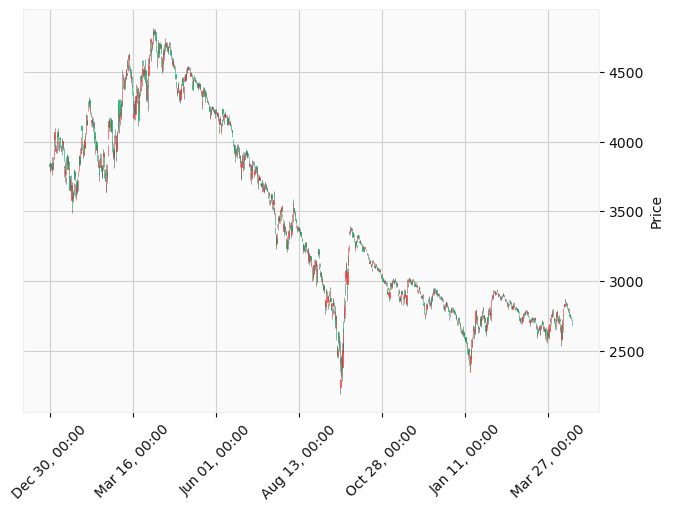

In [224]:
# Plot OHLC chart
mpf.plot(sp500_data_indexed, type='candle', style='yahoo')

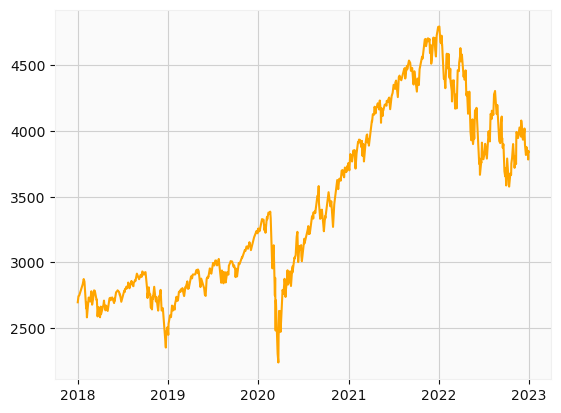

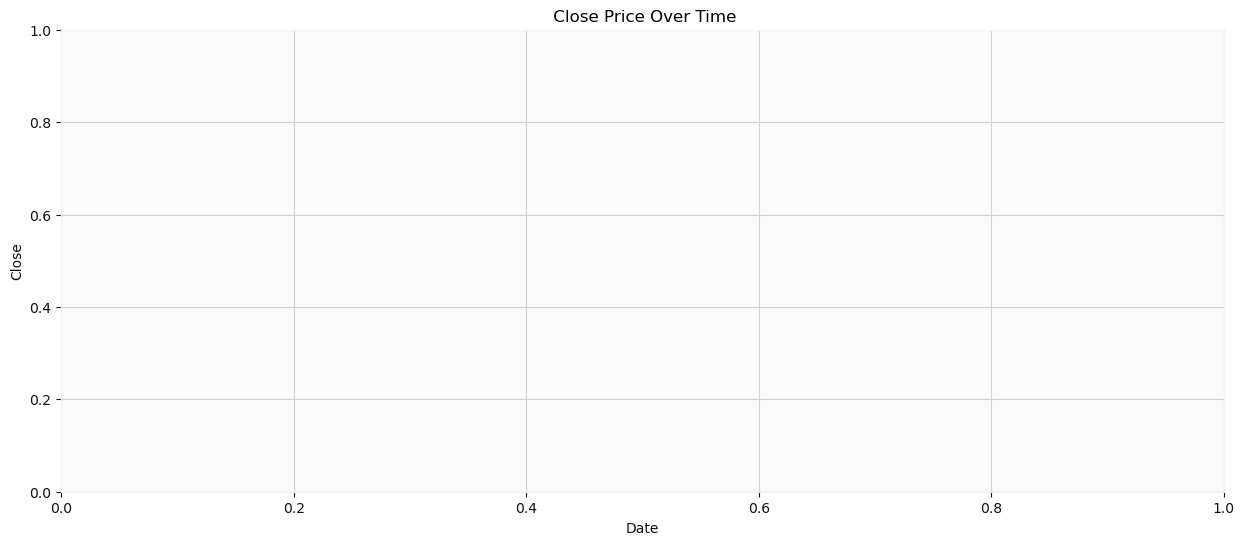

In [228]:
# Plot a line graph of the 'closing_price' column
plt.plot(sp500_data_indexed['Close'], color='orange')
plt.figure(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Close')
plt.title(' Close Price Over Time')
plt.show()

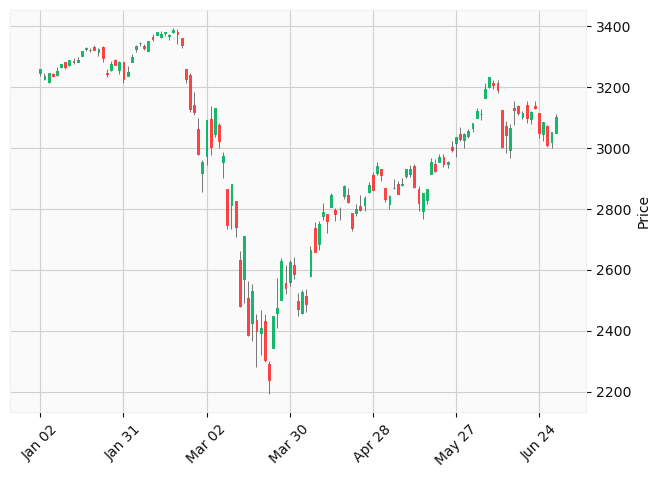

In [234]:
# Sort the DatetimeIndex in ascending order before performing partial slicing
sp500_data_indexed = sp500_data_indexed.sort_index()

# Filter sp500_data for date range between Jan 2020 and June 2020
filtered_data = sp500_data_indexed.loc['2020-01':'2020-06']

# Plot OHLC chart
mpf.plot(filtered_data, type='candle', style='yahoo')

### Descriptive Analytics for the S&P 500

In [131]:
sp500_data_indexed.describe()

,Close,Open,High,Low,Change %
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,3449.736068,3449.634075,3470.856465,3426.302828,0.038348
std,668.917087,668.811903,672.262482,665.160706,1.376915
min,2237.400000,2290.710000,2300.730000,2191.860000,-11.980000
25%,2844.115000,2842.390000,2857.675000,2825.450000,-0.530000
50%,3276.020000,3280.610000,3288.130000,3253.220000,0.090000
75%,4028.935000,4038.645000,4077.880000,3995.845000,0.710000
max,4796.560000,4804.510000,4818.620000,4780.040000,9.380000


### Adding Technical Indicators to the S&P 500 dataset

In [240]:
SP_data.head(1)

,Date,Price,Open,High,Low,Vol.,Change %
0,30/12/2022,"3,839.50","3,829.06","3,839.85","3,800.34",NaN,-0.25%


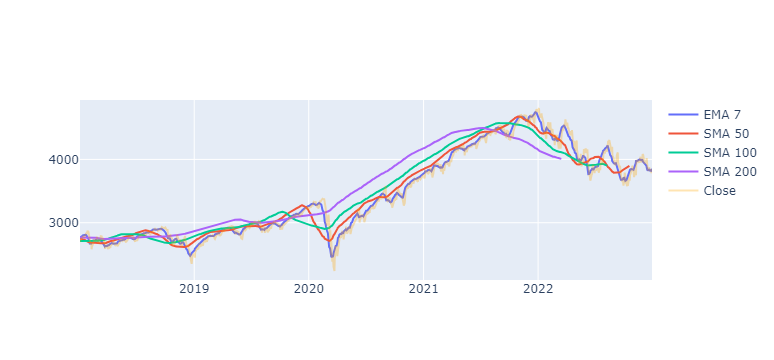

In [838]:
# Calculate and add Exponential Moving Average and Simple Moving Average for various time periods
SP_data['EMA_7'] = SP_data['Close Price'].ewm(5).mean().shift()
SP_data['SMA_50'] = SP_data['Close Price'].rolling(50).mean().shift()
SP_data['SMA_100'] = SP_data['Close Price'].rolling(100).mean().shift()
SP_data['SMA_200'] = SP_data['Close Price'].rolling(200).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=SP_data.Date, y=SP_data['EMA_7'], name='EMA 7'))
fig.add_trace(go.Scatter(x=SP_data.Date, y=SP_data['SMA_50'], name='SMA 50'))
fig.add_trace(go.Scatter(x=SP_data.Date, y=SP_data['SMA_100'], name='SMA 100'))
fig.add_trace(go.Scatter(x=SP_data.Date, y=SP_data['SMA_200'], name='SMA 200'))
fig.add_trace(go.Scatter(x=SP_data.Date, y=SP_data['Close Price'], name='Close', line_color='orange', opacity=0.3))
fig.show()

#Index IN PLACE OF Date IF USING DATASET WITH Index

In [840]:
def calc_rsi(df, window=14):
    close_delta = df['Close Price'].diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ema_up = up.ewm(com=window-1, adjust=False).mean()
    ema_down = down.ewm(com=window-1, adjust=False).mean()
    
    rs = ema_up / ema_down
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

SP_data['RSI'] = calc_rsi(SP_data)

In [842]:
# Check for missing values in the sp500_data DataFrame
SP_data.isnull().any()

Date                 False
Close Price          False
Open Price           False
High Price           False
Low Price            False
Percentage Change    False
EMA_7                 True
SMA_50                True
SMA_100               True
SMA_200               True
RSI                   True
dtype: bool

In [844]:
# Check for missing values in the sp500_data DataFrame
SP_data.isnull().sum()

Date                   0
Close Price            0
Open Price             0
High Price             0
Low Price              0
Percentage Change      0
EMA_7                  1
SMA_50                50
SMA_100              100
SMA_200              200
RSI                    1
dtype: int64

In [846]:
SP_data = SP_data.fillna(method='bfill')

In [848]:
SP_data.isnull().any()

Date                 False
Close Price          False
Open Price           False
High Price           False
Low Price            False
Percentage Change    False
EMA_7                False
SMA_50               False
SMA_100              False
SMA_200              False
RSI                  False
dtype: bool

In [850]:
#read Interest Rate data
InterestRate_data = pd.read_csv('Interest_Rates.csv')

In [852]:
#Rename column headers
InterestRate_data.columns = InterestRate_data.columns.str.replace("DATE", "Date_Int")
InterestRate_data.columns = InterestRate_data.columns.str.replace("FEDFUNDS", "INRATES")

In [854]:
#convert Date_Int to dateTime
InterestRate_data['Date_Int'] = pd.to_datetime(InterestRate_data['Date_Int'], dayfirst=True)

In [856]:
InterestRate_data.head(5)

,Date_Int,INRATES
0,2018-01-01,1.41
1,2018-01-02,1.42
2,2018-01-03,1.51
3,2018-01-04,1.69
4,2018-01-05,1.70


In [858]:
#read Unemployment Rate data
Unemployment_data = pd.read_csv('Unemployment_Rate.csv')

In [860]:
Unemployment_data.columns = Unemployment_data.columns.str.replace("DATE", "Date_UnEmp")

In [862]:
#convert Date_Int to dateTime
Unemployment_data['Date_UnEmp'] = pd.to_datetime(Unemployment_data['Date_UnEmp'], dayfirst=True)

In [864]:
Unemployment_data.dtypes

Date_UnEmp    datetime64[ns]
UNRATE               float64
dtype: object

In [866]:
Unemployment_data.head(5)

,Date_UnEmp,UNRATE
0,2018-01-01,4.0
1,2018-01-02,4.1
2,2018-01-03,4.0
3,2018-01-04,4.0
4,2018-01-05,3.8


In [868]:
#read GDP data
GDP_data = pd.read_csv('GDP.csv')

In [870]:
GDP_data.columns = GDP_data.columns.str.replace("DATE", "Date_GDP")

In [872]:
#convert Date_GDP to dateTime
GDP_data['Date_GDP'] = pd.to_datetime(GDP_data['Date_GDP'], dayfirst=True)

In [874]:
GDP_data.head(5)

,Date_GDP,GDP
0,2018-01-01,20328.553
1,2018-01-04,20580.912
2,2018-01-07,20798.730
3,2018-01-10,20917.867
4,2019-01-01,21104.133


In [876]:
#read Consumer Sentiment data
Consumer_Sentiment_data = pd.read_csv('Consumer_Sentiment.csv')

In [878]:
#Rename column headers
Consumer_Sentiment_data.columns = Consumer_Sentiment_data.columns.str.replace("DATE", "Date_CS")
Consumer_Sentiment_data.columns = Consumer_Sentiment_data.columns.str.replace("UMCSENT", "CONSENT")

In [880]:
#convert Date_CS to dateTime
Consumer_Sentiment_data['Date_CS'] = pd.to_datetime(Consumer_Sentiment_data['Date_CS'], dayfirst=True)

In [882]:
Consumer_Sentiment_data.head(5)

,Date_CS,CONSENT
0,2018-01-01,95.7
1,2018-01-02,99.7
2,2018-01-03,101.4
3,2018-01-04,98.8
4,2018-01-05,98.0


In [884]:
#read CPI data#convert Date_CS to dateTime
CPI_data = pd.read_csv('CPI.csv')

In [886]:
#Rename column headers
CPI_data.columns = CPI_data.columns.str.replace("DATE", "Date_CPI")
CPI_data.columns = CPI_data.columns.str.replace("CPIAUCSL", "CPI")

In [888]:
#convert Date_CS to dateTime
CPI_data['Date_CPI'] = pd.to_datetime(CPI_data['Date_CPI'], dayfirst=True)

In [890]:
CPI_data.head(5)

,Date_CPI,CPI
0,2018-01-01,248.859
1,2018-01-02,249.529
2,2018-01-03,249.577
3,2018-01-04,250.227
4,2018-01-05,250.792


In [892]:
#merge economic data with SP_data
merged_data1 = pd.merge_asof(SP_data.sort_values('Date'), InterestRate_data.sort_values('Date_Int'), 
                            left_on='Date', right_on='Date_Int', direction='nearest')
merged_data1.head(3)

,Date,Close Price,Open Price,High Price,Low Price,Percentage Change,EMA_7,SMA_50,SMA_100,SMA_200,RSI,Date_Int,INRATES
0,2018-01-02,2695.81,2683.73,2695.89,2682.36,0.83,2753.936475,2748.0696,2710.8612,2767.74070,37.213013,2018-01-02,1.42
1,2018-01-03,2713.06,2697.85,2714.37,2697.77,0.64,2762.111770,2748.8486,2710.6292,2768.01930,39.967573,2018-01-03,1.51
2,2018-01-04,2723.99,2719.31,2729.29,2719.07,0.40,2769.736124,2748.6272,2710.6294,2768.23825,41.787483,2018-01-04,1.69


In [894]:
merged_data2 = pd.merge_asof(merged_data1.sort_values('Date'), Unemployment_data.sort_values('Date_UnEmp'), 
                            left_on='Date', right_on='Date_UnEmp', direction='nearest')
merged_data2.head(3)

,Date,Close Price,Open Price,High Price,Low Price,Percentage Change,EMA_7,SMA_50,SMA_100,SMA_200,RSI,Date_Int,INRATES,Date_UnEmp,UNRATE
0,2018-01-02,2695.81,2683.73,2695.89,2682.36,0.83,2753.936475,2748.0696,2710.8612,2767.74070,37.213013,2018-01-02,1.42,2018-01-02,4.1
1,2018-01-03,2713.06,2697.85,2714.37,2697.77,0.64,2762.111770,2748.8486,2710.6292,2768.01930,39.967573,2018-01-03,1.51,2018-01-03,4.0
2,2018-01-04,2723.99,2719.31,2729.29,2719.07,0.40,2769.736124,2748.6272,2710.6294,2768.23825,41.787483,2018-01-04,1.69,2018-01-04,4.0


In [896]:
merged_data3 = pd.merge_asof(merged_data2.sort_values('Date'), GDP_data.sort_values('Date_GDP'), 
                            left_on='Date', right_on='Date_GDP', direction='nearest')
merged_data3.head(3)

,Date,Close Price,Open Price,High Price,Low Price,Percentage Change,EMA_7,SMA_50,SMA_100,SMA_200,RSI,Date_Int,INRATES,Date_UnEmp,UNRATE,Date_GDP,GDP
0,2018-01-02,2695.81,2683.73,2695.89,2682.36,0.83,2753.936475,2748.0696,2710.8612,2767.74070,37.213013,2018-01-02,1.42,2018-01-02,4.1,2018-01-01,20328.553
1,2018-01-03,2713.06,2697.85,2714.37,2697.77,0.64,2762.111770,2748.8486,2710.6292,2768.01930,39.967573,2018-01-03,1.51,2018-01-03,4.0,2018-01-04,20580.912
2,2018-01-04,2723.99,2719.31,2729.29,2719.07,0.40,2769.736124,2748.6272,2710.6294,2768.23825,41.787483,2018-01-04,1.69,2018-01-04,4.0,2018-01-04,20580.912


In [898]:
merged_data4 = pd.merge_asof(merged_data3.sort_values('Date'), Consumer_Sentiment_data.sort_values('Date_CS'), 
                            left_on='Date', right_on='Date_CS', direction='nearest')
merged_data4.head(3)

,Date,Close Price,Open Price,High Price,Low Price,Percentage Change,EMA_7,SMA_50,SMA_100,SMA_200,RSI,Date_Int,INRATES,Date_UnEmp,UNRATE,Date_GDP,GDP,Date_CS,CONSENT
0,2018-01-02,2695.81,2683.73,2695.89,2682.36,0.83,2753.936475,2748.0696,2710.8612,2767.74070,37.213013,2018-01-02,1.42,2018-01-02,4.1,2018-01-01,20328.553,2018-01-02,99.7
1,2018-01-03,2713.06,2697.85,2714.37,2697.77,0.64,2762.111770,2748.8486,2710.6292,2768.01930,39.967573,2018-01-03,1.51,2018-01-03,4.0,2018-01-04,20580.912,2018-01-03,101.4
2,2018-01-04,2723.99,2719.31,2729.29,2719.07,0.40,2769.736124,2748.6272,2710.6294,2768.23825,41.787483,2018-01-04,1.69,2018-01-04,4.0,2018-01-04,20580.912,2018-01-04,98.8


In [900]:
merged_data = pd.merge_asof(merged_data4.sort_values('Date'), CPI_data.sort_values('Date_CPI'), 
                            left_on='Date', right_on='Date_CPI', direction='nearest')

In [902]:
#Save dataset as a csv file.
data = pd.DataFrame(merged_data)
data.to_csv('SP_data_Eco_Tech.csv', index=False)

In [904]:
merged_data.shape

(1259, 21)

In [906]:
merged_data = merged_data.drop(['Date_Int','Date_UnEmp','Date_GDP', 'Date_CS','Date_CPI'],  axis = 1)

In [908]:
merged_data.head(3)

,Date,Close Price,Open Price,High Price,Low Price,Percentage Change,EMA_7,SMA_50,SMA_100,SMA_200,RSI,INRATES,UNRATE,GDP,CONSENT,CPI
0,2018-01-02,2695.81,2683.73,2695.89,2682.36,0.83,2753.936475,2748.0696,2710.8612,2767.74070,37.213013,1.42,4.1,20328.553,99.7,249.529
1,2018-01-03,2713.06,2697.85,2714.37,2697.77,0.64,2762.111770,2748.8486,2710.6292,2768.01930,39.967573,1.51,4.0,20580.912,101.4,249.577
2,2018-01-04,2723.99,2719.31,2729.29,2719.07,0.40,2769.736124,2748.6272,2710.6294,2768.23825,41.787483,1.69,4.0,20580.912,98.8,250.227


In [910]:
#Save dataset as a csv file.
data = pd.DataFrame(merged_data)
data.to_csv('Fin_SP_data_Eco_Tech.csv', index=False)

### Visualization for Merged S&P Data with Economic Data and Technical Indicators

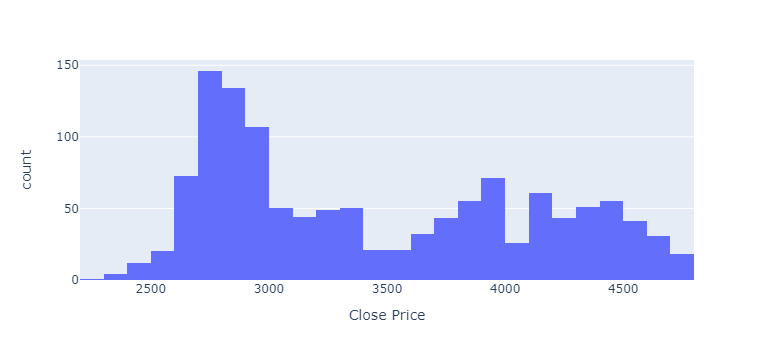

In [609]:
#create a histogram
fig = px.histogram(merged_data, x='Close Price')
fig.show()

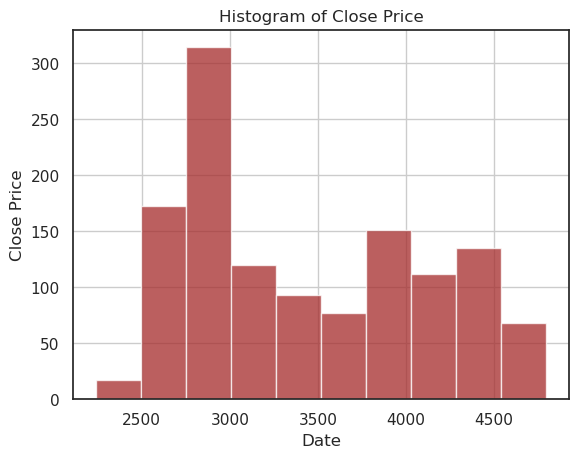

In [611]:
x = merged_data['Close Price']
sns.set_style('white')
plt.hist(y, 10, color= "brown", alpha=0.75)
#plt.ylabel('Date')
#plt.xlabel('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Histogram of Close Price')
#plt.rcParams["figure.figsize"] = (10,5)
plt.grid(True)
plt.show()

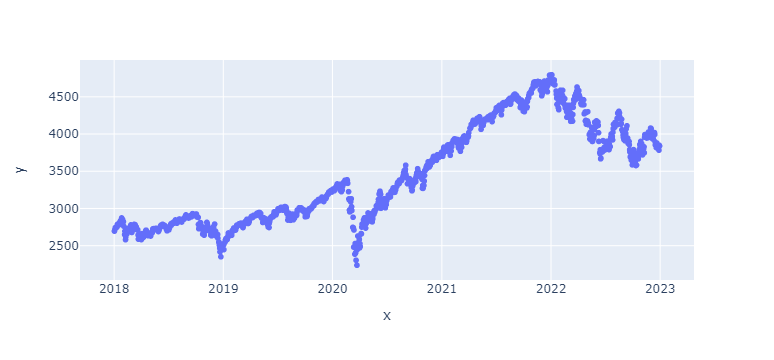

In [613]:
fig = px.scatter(x=merged_data['Date'], y=merged_data['Close Price'])
#px.ylabel('Close Price')
#px.xlabel('Date')
fig.show()

### Descriptive Statistics for Merged S&P Data with Economic Data and Technical Indicators

In [912]:
merged_data_indexed = merged_data.set_index('Date')

In [914]:
merged_data_indexed.describe()

,Close Price,Open Price,High Price,Low Price,Percentage Change,EMA_7,SMA_50,SMA_100,SMA_200,RSI,INRATES,UNRATE,GDP,CONSENT,CPI
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,3449.736068,3449.634075,3470.856465,3426.302828,0.038348,3454.982296,3472.570947,3497.986412,3558.265117,46.207430,1.615449,4.305560,23259.841900,80.619936,270.786134
std,668.917087,668.811903,672.262482,665.160706,1.376915,664.154005,653.774357,640.214558,619.138759,11.508816,1.499503,1.158799,2030.552034,15.155553,17.034616
min,2237.400000,2290.710000,2300.730000,2191.860000,-11.980000,2455.434968,2609.060200,2679.253300,2740.711850,16.356213,0.060000,3.500000,19913.143000,50.000000,249.529000
25%,2844.115000,2842.390000,2857.675000,2825.450000,-0.530000,2846.078505,2867.935800,2906.267250,2995.373600,37.866887,0.090000,3.500000,21706.513000,67.200000,258.616000
50%,3276.020000,3280.610000,3288.130000,3253.220000,0.090000,3288.571044,3326.633400,3378.897500,3615.228500,45.598684,1.550000,3.900000,22024.502000,80.700000,262.035000
75%,4028.935000,4038.645000,4077.880000,3995.845000,0.710000,4014.733663,4010.682900,4026.602050,4050.001750,54.461860,2.400000,4.000000,25029.116000,98.300000,282.599000
max,4796.560000,4804.510000,4818.620000,4780.040000,9.380000,4745.600340,4681.057000,4576.599500,4496.943350,100.000000,4.100000,11.000000,26408.405000,101.400000,298.990000


### Correlative Matrix

In [615]:
most_correlated = merged_data.corr().abs()['Close Price'].sort_values(ascending=False)
most_correlated

Close Price          1.000000
Low Price            0.999337
High Price           0.999244
Open Price           0.998637
EMA_7                0.993708
SMA_50               0.971298
SMA_100              0.953943
SMA_200              0.910684
GDP                  0.886134
Date                 0.865908
CONSENT              0.862098
CPI                  0.851287
RSI                  0.213913
UNRATE               0.180770
INRATES              0.026201
Percentage Change    0.022938
Name: Close Price, dtype: float64

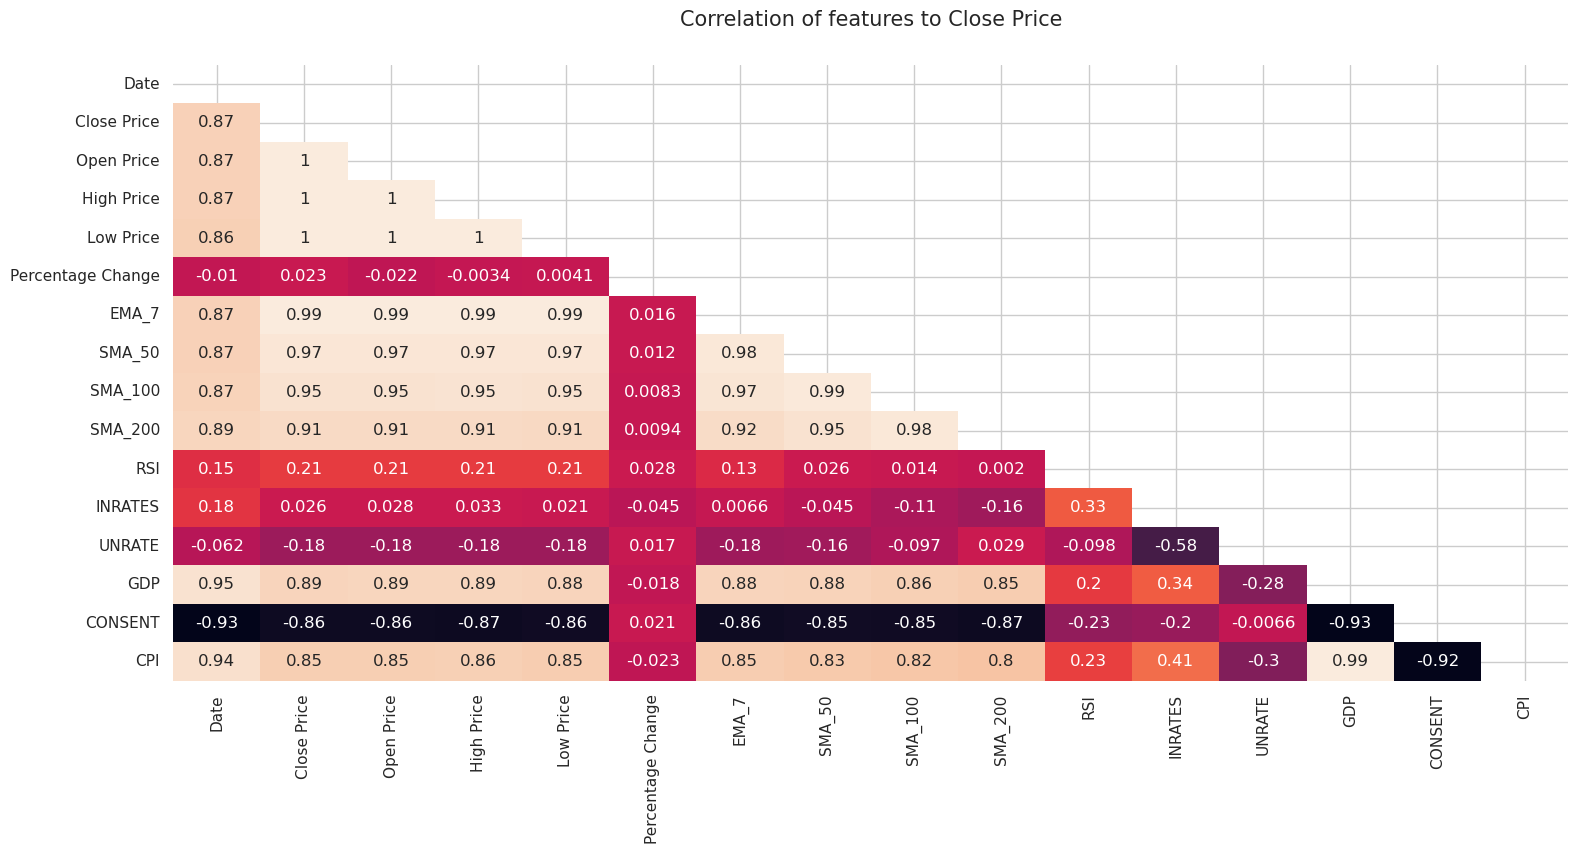

In [372]:
#Creating a heatmap of the correlations between the price and other features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,8))

correlated = merged_data_indexed.corr()

mask = np.triu(np.ones_like(correlated))
plt.title('Correlation of features to Close Price', y=1.05, size=15)
sns.heatmap(correlated, annot=True, cbar=False, mask=mask)
plt.show()
#print(SHUdata.shape)

### Building the ANN and LSTM models for close price only

In [916]:
df = merged_data[['Date', 'Close Price']]

In [918]:
df.head(4)

,Date,Close Price
0,2018-01-02,2695.81
1,2018-01-03,2713.06
2,2018-01-04,2723.99
3,2018-01-05,2743.15


In [920]:
new_df= df.set_index(['Date'], drop=True)

In [922]:
new_df.head(4)

,Close Price
Date,
2018-01-02,2695.81
2018-01-03,2713.06
2018-01-04,2723.99
2018-01-05,2743.15


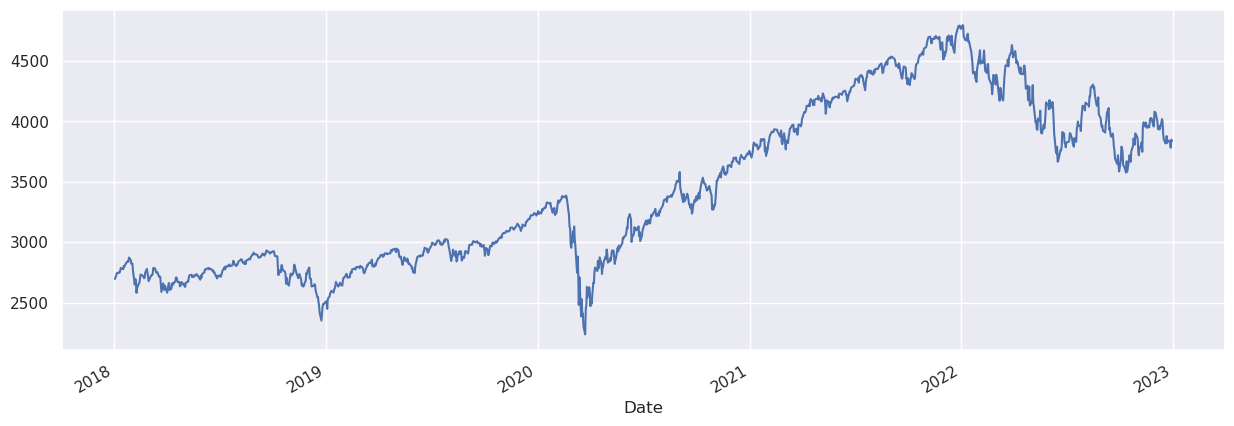

In [924]:
plt.figure(figsize=(15,5))
new_df['Close Price'].plot();

train values length: 1007
train values length: 252


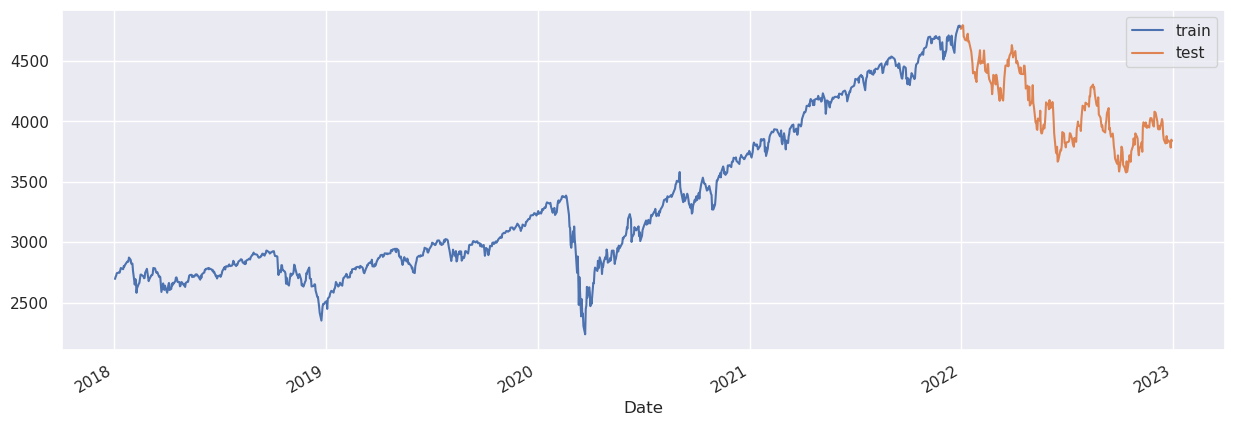

In [926]:
#split data based on a specific timestamp 
split_date = pd.Timestamp('2021-12-31')
df1 = new_df['Close Price']
train = df1.loc[:split_date]
train = train[:-1]
test = df1.loc[split_date:]
plt.figure(figsize=(15,5))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

print("train values length:", len(train))
print("train values length:", len(test))

In [928]:
train_processed = new_df.iloc[:, 0:1].values 
train_processed = train_processed[0:1007:1]
test_processed = new_df.iloc[:, 0:1].values
test_processed = test_processed[1007:1269:1]

In [930]:
#Normalize the data data for LSTM 
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_processed)
test_scaled = scaler.transform(test_processed)

scaled_data = scaler.fit_transform(new_df[['Close Price']])

In [932]:
X_train = train_scaled
y_train = train_scaled
X_test = test_scaled
y_test = test_scaled

### The ANN model

In [935]:
#Build the ANN model
ann_model = Sequential()
ann_model.add(Dense(12, input_dim=1, activation='relu'))
ann_model.add(Dense(1))

#compile the model
ann_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

#fitting the model
ann_model_fitted = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/50
32/32 [==============================] - 1s 2ms/step - loss: 0.4340
Epoch 2/50
32/32 [==============================] - 0s 1ms/step - loss: 0.3164
Epoch 3/50
32/32 [==============================] - 0s 1ms/step - loss: 0.2350
Epoch 4/50
32/32 [==============================] - 0s 1ms/step - loss: 0.1741
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1289
Epoch 6/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0956
Epoch 7/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0712
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0532
Epoch 9/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0400
Epoch 10/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0302
Epoch 11/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 12/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 13/50
32/32 [==============================

In [937]:
# Checking the R2 score

y_test_pred_ann = ann_model.predict(X_test)
y_train_pred_ann = ann_model.predict(X_train)
print("The R2 score for the train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
print("The R2 score for the test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred_ann)))

32/32 [==============================] - 0s 861us/step
The R2 score for the train set is:	0.993
The R2 score for the test set is:	0.928


In [939]:
# Evaluate the model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, y_test_pred_ann)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred_ann)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

actual, predicted = np.array(y_test), np.array(y_test_pred_ann)

#avoid a case of division by zero (0)
denominator = np.where(y_test != 0, actual, 1.)

# Calculate absolute percentage error for each data point
ape = np.abs((y_test - y_test_pred_ann) / denominator)

# Calculate mean absolute percentage error
mape = np.mean(ape) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 0.0037907661206673586
Root Mean Squared Error (RMSE): 0.061569197823809256
Mean Absolute Error (MAE): 0.05500811009792319
Mean Absolute Percentage Error (MAPE): 20.10109526900549%


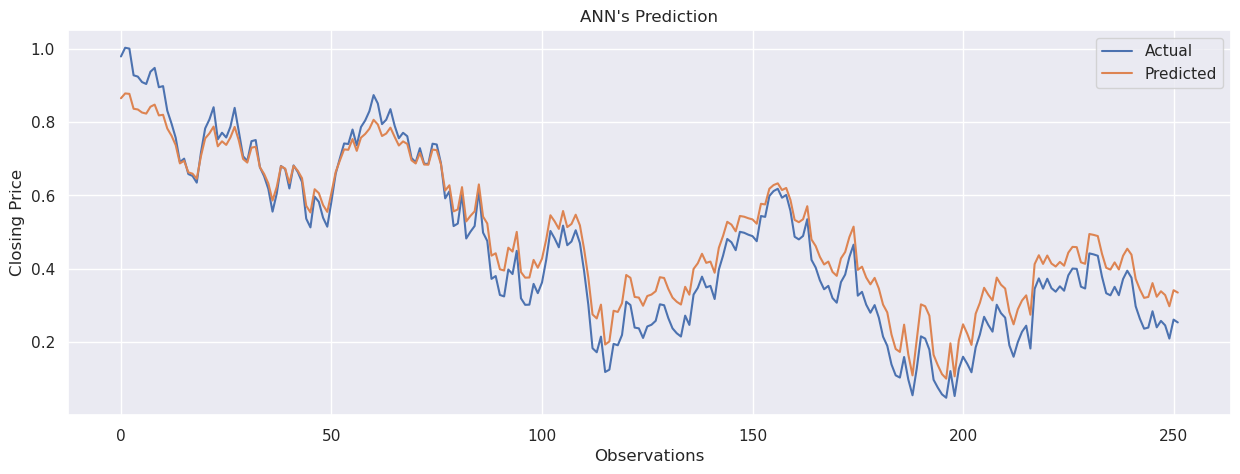

In [941]:
# Plot graph of actual and predicted closing price
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred_ann, label='Predicted')
plt.title("ANN's Prediction")
plt.xlabel('Observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show();

### The LSTM Model

In [944]:
train_scaled_df = pd.DataFrame(train_scaled, columns=['Y'], index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=['Y'], index=test.index)

for s in range(1,2):
    train_scaled_df['X_{}'.format(s)] = train_scaled_df['Y'].shift(s)
    test_scaled_df['X_{}'.format(s)] = test_scaled_df['Y'].shift(s)

train_scaled_df = train_scaled_df.fillna(method='bfill')

X_train = train_scaled_df.drop('Y', axis=1)
y_train = train_scaled_df.drop('X_1', axis=1)

test_scaled_df = test_scaled_df.fillna(method='bfill')

X_test = test_scaled_df.drop('Y', axis=1)
y_test = test_scaled_df.drop('X_1', axis=1)

X_train = X_train['X_1']
y_train = y_train['Y']
X_test = X_test['X_1']
y_test = y_test['Y']

X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

In [946]:
#Rescale the x_train and y_train for LSTM 

X_train_lmse = X_train.reshape(X_train.shape[0], 1, 1)
X_test_lmse = X_test.reshape(X_test.shape[0], 1, 1)

In [948]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))

#compile the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

#fitting the model
lstm_model_fitted = lstm_model.fit(X_train_lmse, y_train, epochs=50, batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
32/32 [==============================] - 2s 3ms/step - loss: 0.2806
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.2514
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.2282
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.2062
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1855
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 0.1660
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1478
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1311
Epoch 9/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1160
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1023
Epoch 11/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0900
Epoch 12/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0789
Epoch 13/50
32/32 [==============================

In [950]:
#Check the R2 score
y_test_pred_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

32/32 [==============================] - 0s 1ms/step
The R2 score on the Train set is:	0.985
The R2 score on the Test set is:	0.952


In [952]:
# Evaluate the model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, y_test_pred_lstm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred_lstm)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

actual, predicted = np.array(y_test), np.array(y_test_pred_lstm)

#avoid a case of division by zero (0)
denominator = np.where(y_test != 0, actual, 1.)

# Calculate absolute percentage error for each data point
ape = np.abs((y_test - y_test_pred_lstm) / denominator)

# Calculate mean absolute percentage error
mape = np.mean(ape) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 0.010459417989683502
Root Mean Squared Error (RMSE): 0.10227129602035706
Mean Absolute Error (MAE): 0.08832909512321589
Mean Absolute Percentage Error (MAPE): 89.40567768420851%


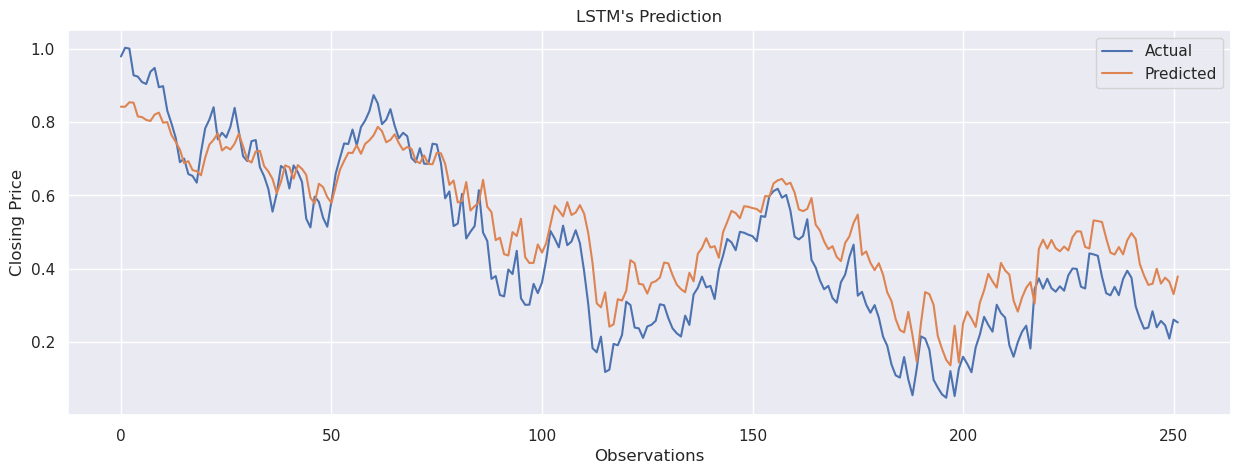

In [954]:
# Plot graph of actual and predicted closing price
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred_lstm, label='Predicted')
plt.title("LSTM's Prediction")
plt.xlabel('Observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show();

### Combination of ANN and LSTM into a hybrid

In [956]:
#Combine ANN and LSTM predictions
final_prediction = y_test_pred_ann + y_test_pred_lstm

In [958]:
#Evaluate the performance of the hybrid model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, final_prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, final_prediction)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

actual, predicted = np.array(y_test), np.array(final_prediction)

#avoid a case of division by zero (0)
denominator = np.where(y_test != 0, actual, 1.)

# Calculate absolute percentage error for each data point
ape = np.abs((y_test - final_prediction) / denominator)

# Calculate mean absolute percentage error
mape = np.mean(ape) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 0.3297310038572055
Root Mean Squared Error (RMSE): 0.5742220858319589
Mean Absolute Error (MAE): 0.5601560655873778
Mean Absolute Percentage Error (MAPE): 224.59138816554662%


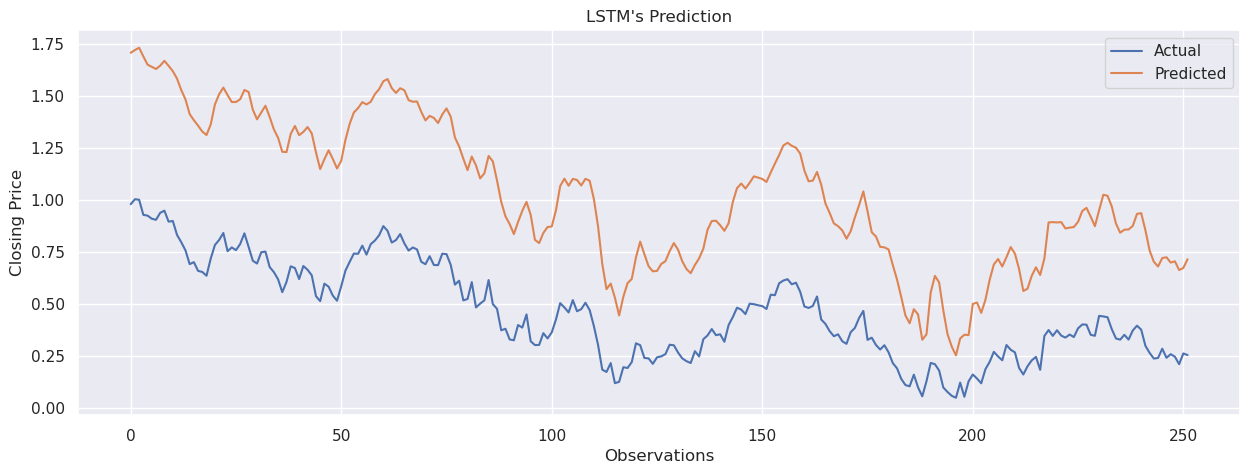

In [962]:
# Plot graph of actual and predicted closing price
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(final_prediction, label='Predicted')
plt.title("LSTM's Prediction")
plt.xlabel('Observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show();

In [964]:
# Inverse scaling for predictions
predicted = scaler.inverse_transform(final_prediction.reshape(-1, 1))

# Inverse scaling for actual values
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [966]:
Date = test.index

In [967]:
data = {'Date': Date, 'Actual': actual.flatten(), 'Predicted': predicted.flatten()}
df = pd.DataFrame(data)

df.head(10)

,Date,Actual,Predicted
0,2021-12-31,4769.643188,5701.251465
1,2022-01-03,4800.064793,5717.997559
2,2022-01-04,4797.040657,5732.093262
3,2022-01-05,4703.953348,5678.585938
4,2022-01-06,4699.417144,5628.137207
5,2022-01-07,4680.361082,5615.140625
6,2022-01-10,4673.621865,5601.444336
7,2022-01-11,4716.460453,5621.836914
8,2022-01-12,4729.758640,5651.567871
9,2022-01-13,4662.336431,5620.813965


### Building the ANN and LSTM models for close price, macroeconomic data and technical indicators

In [970]:
features = merged_data.drop(['Open Price','High Price','Low Price'], axis = 1)
features.head(2)

features = features.set_index('Date')

# Define the input features and target variable
X = features.drop(['Close Price'], axis = 1)  
y = features['Close Price']  

In [972]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [974]:
# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

In [976]:
y_train_scaled.shape

(1007, 1)

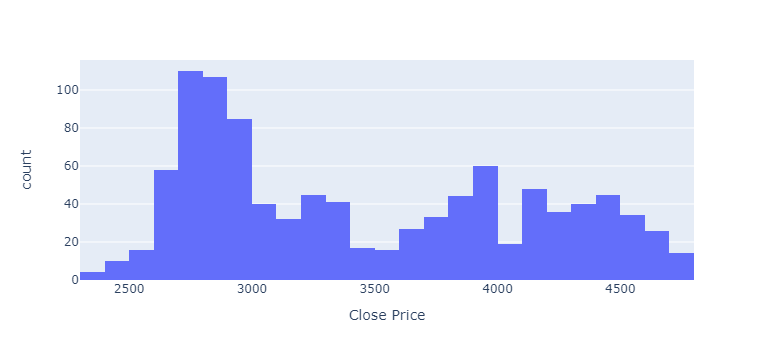

In [507]:
fig = px.histogram(y_train, x='Close Price')
fig.show()

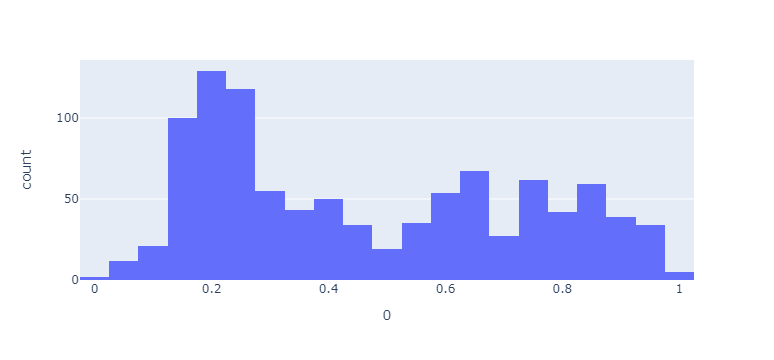

In [509]:
# Convert it to a pandas DataFrame or Series
y_train_scaled_df = pd.DataFrame(y_train_scaled)

# Now you can use the hist() method
#X_train_scaled_df.hist()

fig = px.histogram(y_train_scaled_df, x=0)
fig.show()

### The ANN Model

In [978]:
#Building the ANN model 
ann_model = Sequential()
ann_model.add(Dense(12, input_dim=11, activation='relu'))
ann_model.add(Dense(1))

#compile the model
ann_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

#fit the model
ann_model_fitted = ann_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/50
32/32 [==============================] - 1s 1ms/step - loss: 0.3999
Epoch 2/50
32/32 [==============================] - 0s 1ms/step - loss: 0.2176
Epoch 3/50
32/32 [==============================] - 0s 1ms/step - loss: 0.1188
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0546
Epoch 5/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0278
Epoch 6/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0163
Epoch 7/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 8/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 9/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 10/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 11/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 12/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 13/50
32/32 [==============================

In [980]:
#Checking the R2 score
y_test_pred_ann2 = ann_model.predict(X_test_scaled)
y_train_pred_ann2 = ann_model.predict(X_train_scaled)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_scaled, y_train_pred_ann2)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_scaled, y_test_pred_ann2)))

32/32 [==============================] - 0s 926us/step
The R2 score on the Train set is:	0.992
The R2 score on the Test set is:	0.976


In [982]:
y_test_pred_ann2.shape, y_train_pred_ann2.shape

((252, 1), (1007, 1))

In [984]:
# Evaluate the model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test_scaled, y_test_pred_ann2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, y_test_pred_ann2)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

actual, predicted = np.array(y_test_scaled), np.array(y_test_pred_ann2)

#avoid a case of division by zero (0)
denominator = np.where(y_test_scaled != 0, actual, 1.)

# Calculate absolute percentage error for each data point
ape = np.abs((y_test_scaled - y_test_pred_ann2) / denominator)

# Calculate mean absolute percentage error
mape = np.mean(ape) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 0.0016446891374839148
Root Mean Squared Error (RMSE): 0.040554767136354204
Mean Absolute Error (MAE): 0.03000277228260021
Mean Absolute Percentage Error (MAPE): 8.036140120774919%


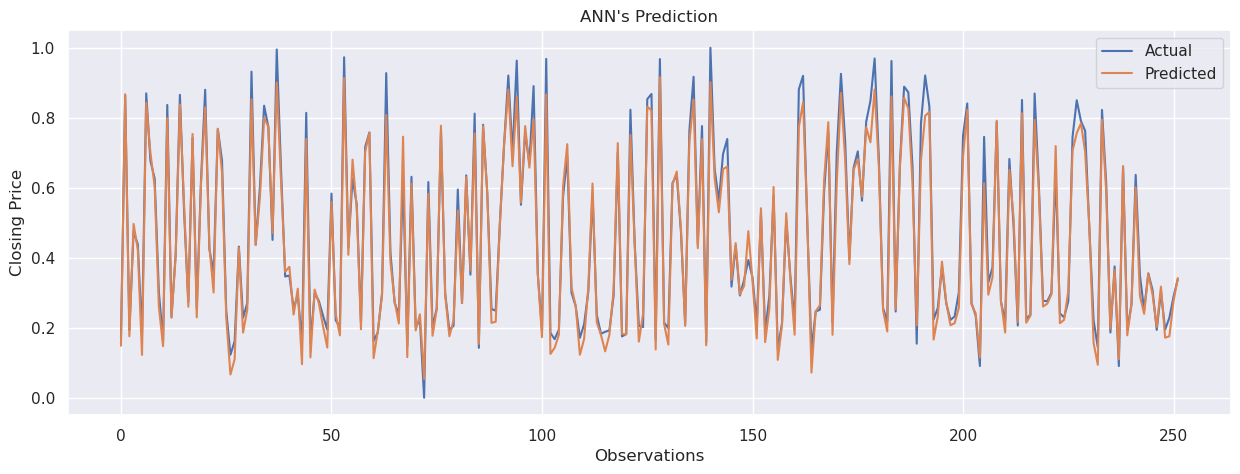

In [986]:
# Plot graph of actual and predicted closing price
plt.figure(figsize=(15, 5))
plt.plot(y_test_scaled, label='Actual')
plt.plot(y_test_pred_ann2, label='Predicted')
plt.title("ANN's Prediction")
plt.xlabel('Observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show();

### The LSTM model

In [988]:
X_train_scaled.shape, y_train_scaled.shape

((1007, 11), (1007, 1))

In [990]:
# Build the LSTM model
lstm_model = Sequential([
    Input(shape=(X_train_scaled.shape[1], 1)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])

In [992]:
#compile the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
#early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

#fit the model
lstm_model_fitted = lstm_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=1) 

Epoch 1/50
32/32 [==============================] - 4s 8ms/step - loss: 0.0694
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0121
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0053
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 6/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0035
Epoch 7/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 9/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0030
Epoch 11/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 12/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 13/50
32/32 [============================

In [994]:
#Check R2 score

y_test_pred_lstm2 = lstm_model.predict(X_test_scaled)
y_train_pred_lstm2 = lstm_model.predict(X_train_scaled)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_scaled, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_scaled, y_pred_test_lstm)))

32/32 [==============================] - 0s 4ms/step
The R2 score on the Train set is:	-8.993
The R2 score on the Test set is:	-0.781


In [996]:
X_test_scaled.shape, y_train_pred_lstm2.shape, X_train_scaled.shape, y_test_pred_lstm2.shape

((252, 11), (1007, 1), (1007, 11), (252, 1))

In [998]:
# Evaluate the model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test_scaled, y_test_pred_lstm2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, y_test_pred_lstm2)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

actual, predicted = np.array(y_test_scaled), np.array(y_test_pred_lstm2)

#avoid a case of division by zero (0)
denominator = np.where(y_test_scaled != 0, actual, 1.)

# Calculate absolute percentage error for each data point
ape = np.abs((y_test_scaled - y_test_pred_lstm2) / denominator)

# Calculate mean absolute percentage error
mape = np.mean(ape) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 0.0065826117588680955
Root Mean Squared Error (RMSE): 0.08113329624061934
Mean Absolute Error (MAE): 0.07069715761404062
Mean Absolute Percentage Error (MAPE): 18.357335943788005%


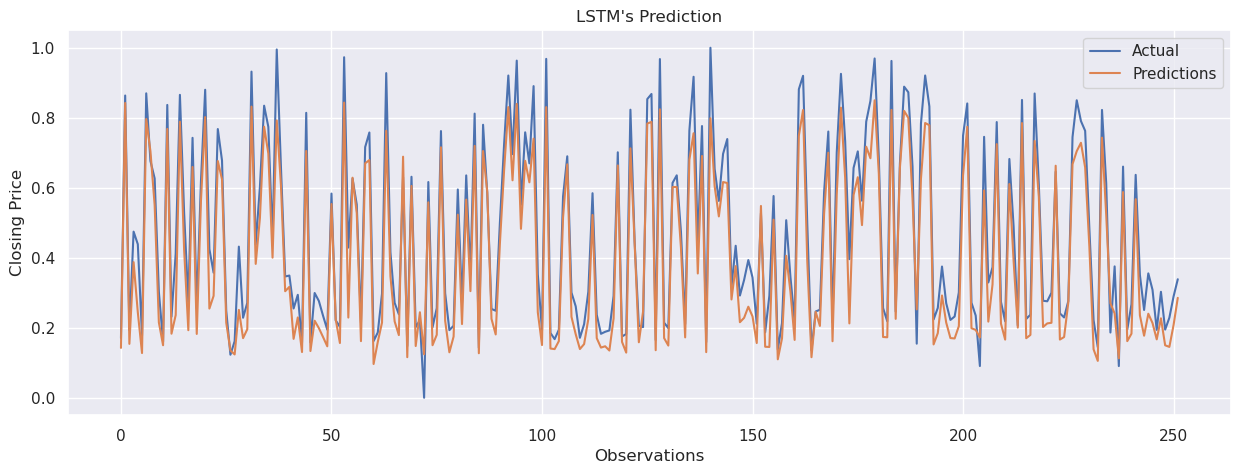

In [1000]:
plt.figure(figsize=(15,5))
plt.plot(y_test_scaled, label='Actual')
plt.plot(y_test_pred_lstm2, label='Predictions')
plt.title("LSTM's Prediction")
plt.xlabel('Observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show();

In [1002]:
# Combine ANN and LSTM predictions

final_pred = y_pred_test_ann2 + y_pred_test_lstm2

In [1004]:
final_pred.shape, y_pred_test_ann2.shape, y_pred_test_lstm2.shape 

((252, 1), (252, 1), (252, 1))

In [1006]:
#Evaluate the performance of the hybrid model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test_scaled, final_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, final_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

actual, predicted = np.array(y_test_scaled), np.array(final_pred)

#avoid a case of division by zero (0)
denominator = np.where(y_test_scaled != 0, actual, 1.)

# Calculate absolute percentage error for each data point
ape = np.abs((y_test_scaled - final_pred) / denominator)

# Calculate mean absolute percentage error
mape = np.mean(ape) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 0.19365087703459335
Root Mean Squared Error (RMSE): 0.4400578110141818
Mean Absolute Error (MAE): 0.3579483514782196
Mean Absolute Percentage Error (MAPE): 70.5755081036931%


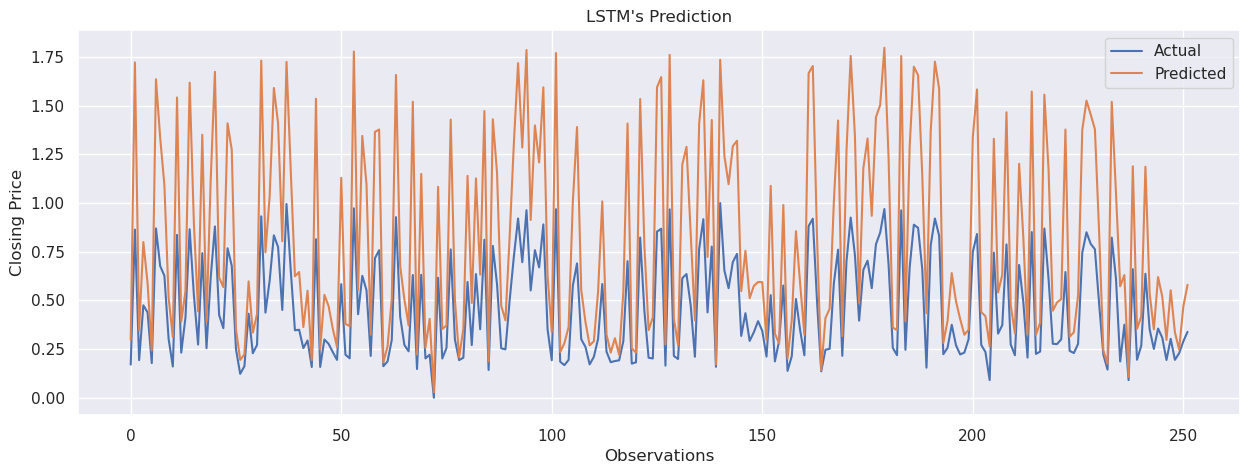

In [1028]:
# Plot graph of actual and predicted closing price
plt.figure(figsize=(15, 5))
plt.plot(y_test_scaled, label='Actual')
plt.plot(final_pred, label='Predicted')
plt.title("LSTM's Prediction")
plt.xlabel('Observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show();

In [1008]:
final_pred.shape, y_test_scaled.shape

((252, 1), (252, 1))

In [1010]:
scaler = MinMaxScaler()
scaler.fit(y_train_scaled)  # Fit the scaler to the training data before using inverse_transform

predicted2 = scaler.inverse_transform(final_pred.reshape(-1, 1))
actual2 = scaler.inverse_transform(y_test_scaled).reshape(-1, 1)

In [1012]:
# Assuming final_pred is a NumPy array
final_pred_df = pd.DataFrame(final_pred, columns=['Close Price'])

# Inverse scaling for predictions
predicted2 = scaler.inverse_transform(final_pred_df)
predicted1 = scaler.fit_transform(final_pred_df)



In [1014]:
final_pred_df

,Close Price
0,0.297433
1,1.722181
2,0.346596
3,0.799971
4,0.588513
...,...
247,0.551999
248,0.336142
249,0.248329
250,0.468211


In [1016]:
Date2 = y_test.index

In [1018]:
import pandas as pd

# Assuming normalized_data is your DataFrame with normalized values
# Replace these values with the parameters used during normalization
min_value = 0  # Replace with the minimum value used during normalization
max_value = 1  # Replace with the maximum value used during normalization

# Revert normalization
predicted2 = final_pred * (max_value - min_value) + min_value
actual2 = y_test_scaled * (max_value - min_value) + min_value

In [1020]:
hybrid_data = {'Date': Date2, 'Actual': y_test_scaled.flatten(), 'Predicted': final_pred.flatten()}
hybrid_df = pd.DataFrame(hybrid_data)

hybrid_df.head(10)

,Date,Actual,Predicted
0,2018-04-23,0.170340,0.297433
1,2022-01-28,0.863505,1.722181
2,2018-03-06,0.193096,0.346596
3,2020-08-25,0.474641,0.799971
4,2020-02-10,0.438625,0.588513
5,2018-05-29,0.178041,0.242954
6,2021-08-11,0.869741,1.635745
7,2022-11-10,0.676406,1.334845
8,2021-02-03,0.626747,1.092047
9,2019-10-21,0.302723,0.514141


In [1022]:
hybrid_data = {'Date': Date2, 'Actual': actual2.flatten(), 'Predicted': predicted2.flatten()}
hybrid_df = pd.DataFrame(hybrid_data)

hybrid_df.head(10)

,Date,Actual,Predicted
0,2018-04-23,0.170340,0.297433
1,2022-01-28,0.863505,1.722181
2,2018-03-06,0.193096,0.346596
3,2020-08-25,0.474641,0.799971
4,2020-02-10,0.438625,0.588513
5,2018-05-29,0.178041,0.242954
6,2021-08-11,0.869741,1.635745
7,2022-11-10,0.676406,1.334845
8,2021-02-03,0.626747,1.092047
9,2019-10-21,0.302723,0.514141


In [1024]:
prediction_df = df
prediction_df.head(3)

,Date,Actual,Predicted
0,2021-12-31,4769.643188,5701.251465
1,2022-01-03,4800.064793,5717.997559
2,2022-01-04,4797.040657,5732.093262


In [1026]:
#Save dataset as a csv file.
data = pd.DataFrame(prediction_df)
data.to_csv('dashboard_data.csv', index=False)

In [ ]:
import requests
import json

predictions = prediction_df

# Flask app URL hosted on PythonAnywhere
flask_app_url = 'http://papi501.pythonanywhere.com/'

# API endpoint to send predictions
api_endpoint = f'{flask_app_url}/'

# Prepare data in JSON format
data = {'predictions': predictions}
headers = {'Content-Type': 'application/json'}

# Send predictions to Flask app
response = requests.post(api_endpoint, data=json.dumps(data), headers=headers)

# Check the response
print(response.text)
